<h1 align=center><font size = 6>Capstone Project - The Battle of Neighborhoods</font></h1>

<h1 align=center><font size = 5>Which hotel to stay in New York?</font></h1>

## 1. Introduction

### 1.1. Background

Due to the outbreak of Coronavirus in the world and the growing cases presented by World Health Organization (WHO), the United States has become the epicenter of this epidemic, with New York (NY) State being the state with the most confirmed positive cases. In order to help reduce the number of positive cases and the rapid spread of the virus (COVID-19), WHO has appointed specialist doctors from different countries to the United States, with the New York as its initial destination. However, the WHO delegation needs to find a strategic hotel to stay at.

### 1.2. Business Problem

The quick way of COVID-19 contagion has proved to be a major challenge for front line professionals, so the WHO delegation intends to take all precautions, staying in a Hotel located in the County with major positive cases of COVID-19 in NY State (to address the pandemic), but closest (less than 1.5 KM) to hospitals for first aid purposes.

### 1.3. Data Sources

In order to achieve the goal of this project, in this project we will be using the following data sources:
##### I. Geodata of Hotels and Hospitals in New York using Foursquare API
We will get all the hotels and hospitals located on the county with major confirmed cases of COVID-19 in NY State, using Foursquare API.
##### II. Dataset of New York State Statewide COVID-19 Testing
This dataset includes information on the number of tests of individuals for
COVID-19 infection performed in New York State beginning March 1, 2020,
when the first case of COVID-19 was identified in the state. The primary goal
of publishing this dataset is to provide users timely information about local
disease spread and reporting of positive cases.
The Dataset can be found on: https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e

### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction</a>

2. <a href="#item1">Download and Explore Dataset</a>

3. <a href="#item2">Load and Explore Hotels with Foursquare</a>

4. <a href="#item3">Analyze Each Hotels</a>

5. <a href="#item4">Results and Recommendations</a>
</font>
</div>

Before we get started, let's import all the packages and dependencies we need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

## 2. Download and Explore Dataset

### Downloading NYS COVID-19 Testing Data

Let's download the data of New York State Statewide COVID-19 Testing and save it as a CSV file called **New_York_State_Statewide_COVID-19.csv**

In [2]:
!wget -q -O 'New_York_State_Statewide_COVID-19.csv' https://health.data.ny.gov/api/views/xdss-u53e/rows.csv?accessType=DOWNLOAD&bom=true&format=true
print('New York COVID-19 Data downloaded!')

New York COVID-19 Data downloaded!


Now that the data is downloaded, let's read it into a pandas dataframe

In [3]:
# If You can not download the file use direct link on read_csv as: 
# newyork_covid_df = pd.read_csv('https://health.data.ny.gov/api/views/xdss-u53e/rows.csv?accessType=DOWNLOAD&bom=true&format=true')
newyork_covid_df = pd.read_csv('New_York_State_Statewide_COVID-19.csv')
newyork_covid_df.head()

,Test Date,County,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed
0,04/18/2020,Albany,34,682,305,7032
1,04/18/2020,Allegany,0,30,7,355
2,04/18/2020,Bronx,804,28823,2162,58605
3,04/18/2020,Broome,6,192,52,1383
4,04/18/2020,Cattaraugus,0,34,17,471


Let's look the size of our Dataframe

In [4]:
newyork_covid_df.shape

(2976, 6)

Rename the columns for shortnames and create a new dataframe with the needed columns to simplify the analysis

In [5]:
#Rename the Columns
newyork_covid_df.rename(columns={'Cumulative Number of Positives':'Total Positives','Cumulative Number of Tests Performed':'Tests Performed'}, inplace=True)

# Create a new Dataframe with relevant columns for analysis
ny_covid_df = newyork_covid_df[['Test Date','County','Total Positives','Tests Performed']]

# get the first 5 rows
ny_covid_df.head()

,Test Date,County,Total Positives,Tests Performed
0,04/18/2020,Albany,682,7032
1,04/18/2020,Allegany,30,355
2,04/18/2020,Bronx,28823,58605
3,04/18/2020,Broome,192,1383
4,04/18/2020,Cattaraugus,34,471


#### Get the last update data of the New York State COVID-19 Testing DataSet

In [8]:
# get the Data of the last updated file
ny_covid_df = ny_covid_df[ny_covid_df['Test Date'] == ny_covid_df['Test Date'].max()]

# get the first 10 rows orderby Total Positives
ny_covid_df.sort_values(['Total Positives'],ascending=False).head(10).style.background_gradient(cmap='Reds', subset = ['Total Positives'])

,Test Date,County,Total Positives,Tests Performed
40,04/18/2020,Queens,41237,80404
23,04/18/2020,Kings,36482,74825
29,04/18/2020,Nassau,30013,69293
2,04/18/2020,Bronx,28823,58605
51,04/18/2020,Suffolk,26888,65320
59,04/18/2020,Westchester,23803,71741
30,04/18/2020,New York,18220,46204
42,04/18/2020,Richmond,9674,23535
43,04/18/2020,Rockland,9364,21949
35,04/18/2020,Orange,6379,18499


In [9]:
# Show the new size
ny_covid_df.shape

(62, 4)

#### Let's plot the TOP 15 Counties with major Tests performed and Confirmed cases of COVID-19 in New York State

Text(0.5, 1.0, 'Top 15 counties as per Number of Tests Performed')

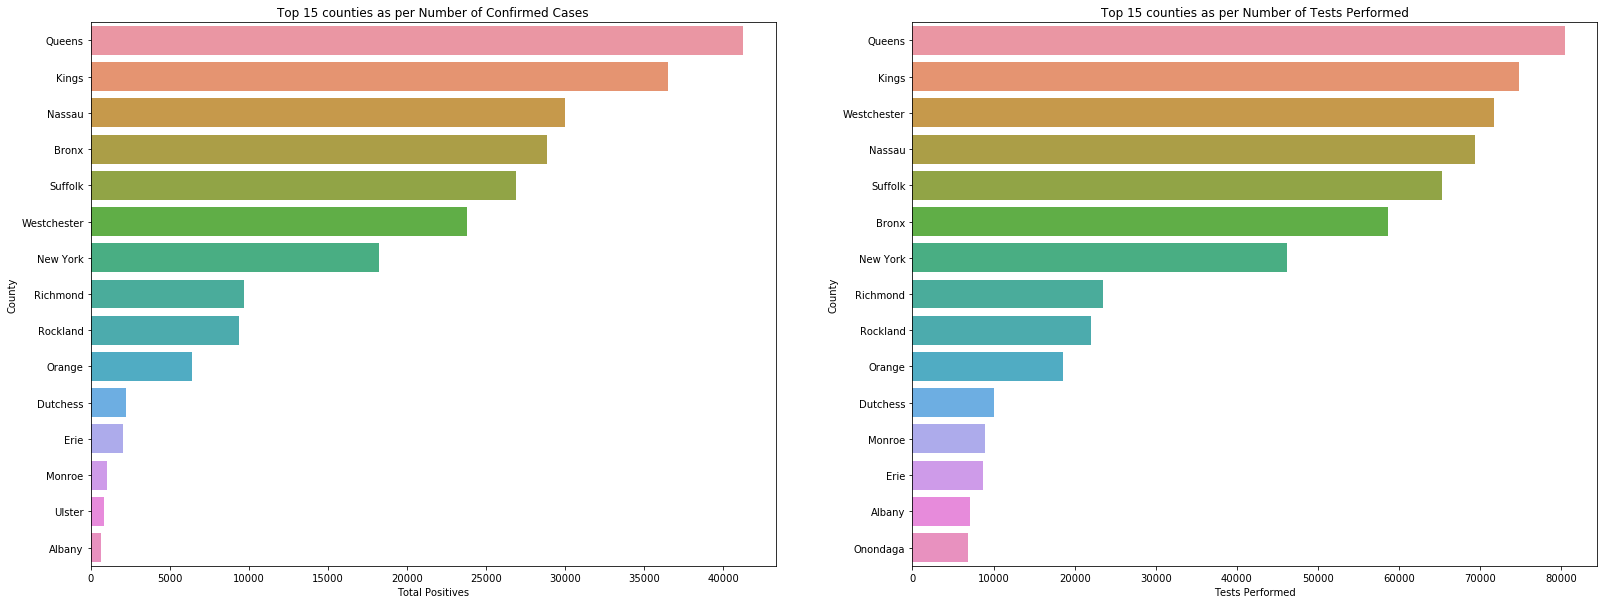

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(27,10))

# get the top 15 counties with confirmed cases
top_15_confirmed = ny_covid_df.sort_values(['Total Positives'],ascending=False).head(15)

# get the top 15 counties with Tests performed
top_15_tested = ny_covid_df.sort_values(['Tests Performed'],ascending=False).head(15)

# Plot of Confirmed Cases
sns.barplot(x=top_15_confirmed['Total Positives'],y=top_15_confirmed['County'],ax=ax1)
ax1.set_title("Top 15 counties as per Number of Confirmed Cases")

# Plot of Tests performed
sns.barplot(x=top_15_tested['Tests Performed'],y=top_15_tested['County'],ax=ax2)
ax2.set_title("Top 15 counties as per Number of Tests Performed")

As the plots above is showing, **Queens** is the County with major numbers of *Tests Performed* and *Confirmed cases*. We can filter our dataframe by getting the row with maximum of Total Positives to see the result.

In [11]:
ny_covid_fewer_df = ny_covid_df[ny_covid_df['Total Positives'] == ny_covid_df['Total Positives'].max()]
ny_covid_fewer_df

,Test Date,County,Total Positives,Tests Performed
40,04/18/2020,Queens,41237,80404


#### Let's plot and analyze the Daily Increase in Number of Confirmed Cases and the Tests Performed in **Queens**

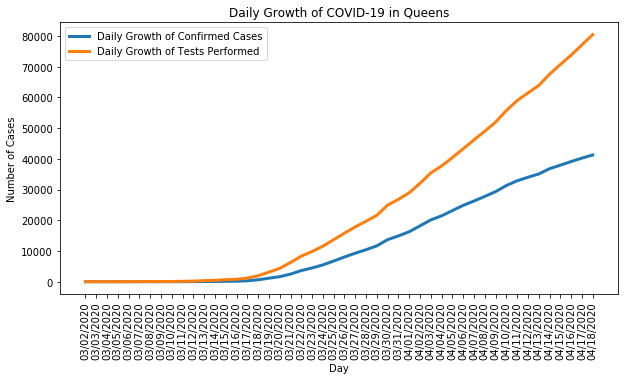

In [12]:
queens_covid_df = newyork_covid_df[newyork_covid_df['County'] == 'Queens'].sort_values(['Test Date'],ascending=True)

plt.figure(figsize=(10,5))

plt.plot(queens_covid_df['Test Date'],queens_covid_df['Total Positives'],linewidth=3,label="Daily Growth of Confirmed Cases")

plt.plot(queens_covid_df['Test Date'],queens_covid_df['Tests Performed'],linewidth=3,label="Daily Growth of Tests Performed")

plt.xticks(rotation=90)
plt.xlabel('Day')
plt.ylabel("Number of Cases")
plt.title("Daily Growth of COVID-19 in Queens")
plt.legend()

We can see that the numbers of *Confirmed cases* grows through the number of *Tests performed* in Queens. Queens is the fourth most densely populated county among **New York City's** boroughs, as well as in the United States. As your probably realize, Queens is also a borough of New York City. Looking back to our Business Problem, **Queens** match with the requirements, so let´s search and explore all the hotels of Queens as well as the latitude and longitude coordinates of each Hotels using **FOURSQUARE.**

## 3. Load and Explore Hotels with Foursquare

##### Let´s Define Our Foursquare Credentials and Version

In [13]:
# @hidden_cell
CLIENT_ID = 'RVFUSF5CON50VCX4GDD0VUX2YRUDAGDX02J2FNCGNKSWFY2Y' # your Foursquare ID
CLIENT_SECRET = 'JUL2SWWNI51UFBVPRC2QRL331RLYOLW1NP2LPJOQA5DQZ4IV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's define a query to search for Hotels that is within 2.5 km from Queens

In [14]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="queens_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [15]:
search_query = 'Hotel'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query,radius, LIMIT)

#### Send the GET Request and examine the results

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea28408aba297001b57ee99'},
 'response': {'venues': [{'id': '50a98748e4b0a916ac044c6e',
    'name': 'Michelle Hotel',
    'location': {'lat': 40.766609386234855,
     'lng': -73.77337971618078,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.766609386234855,
       'lng': -73.77337971618078}],
     'distance': 2770,
     'postalCode': '11361',
     'cc': 'US',
     'city': 'Bayside',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['Bayside, NY 11361', 'United States']},
    'categories': [{'id': '4bf58dd8d48988d1d5941735',
      'name': 'Hotel Bar',
      'pluralName': 'Hotel Bars',
      'shortName': 'Hotel Bar',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1587709322',
    'hasPerk': False},
   {'id': '4f11ff3ce4b04720455ff9a1',
    'name': 'Hotel Aramie',
    'location': {'lat': 40.7570079698

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [17]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address
0,50a98748e4b0a916ac044c6e,Michelle Hotel,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",v-1587709322,False,40.766609,-73.773380,"[{'label': 'display', 'lat': 40.76660938623485...",2770,11361,US,Bayside,NY,United States,"[Bayside, NY 11361, United States]",NaN
1,4f11ff3ce4b04720455ff9a1,Hotel Aramie,[],v-1587709322,False,40.757008,-73.810927,"[{'label': 'display', 'lat': 40.75700796987974...",1377,11355,US,Flushing,NY,United States,"[Flushing, NY 11355, United States]",NaN
2,4bdf1f687ea362b55e5743c4,Ski Und Golfresort Hotel Riml Obergurgl,"[{'id': '4bf58dd8d48988d1ea941735', 'name': 'A...",v-1587709322,False,40.749071,-73.812082,"[{'label': 'display', 'lat': 40.74907103988107...",1221,NaN,US,Obergurgl,NY,United States,"[Hochgurglerstrasse 16, Obergurgl, NY, United ...",Hochgurglerstrasse 16
3,4d2fbf987791224b2ae2ca42,Double tree hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1587709322,False,40.753359,-73.828031,"[{'label': 'display', 'lat': 40.75335927099596...",2593,NaN,US,NaN,New York,United States,"[New York, United States]",NaN
4,4e6c41e752b1456286475c7f,Jinfeng Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1587709322,False,40.757871,-73.820400,"[{'label': 'display', 'lat': 40.757871, 'lng':...",2118,11355,US,Flushing,NY,United States,"[143-49 Ash Ave, Flushing, NY 11355, United St...",143-49 Ash Ave


#### Define information of interest and filter dataframe

In [21]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,id
0,Michelle Hotel,Hotel Bar,40.766609,-73.773380,"[{'label': 'display', 'lat': 40.76660938623485...",2770,11361,US,Bayside,NY,United States,"[Bayside, NY 11361, United States]",NaN,50a98748e4b0a916ac044c6e
1,Hotel Aramie,None,40.757008,-73.810927,"[{'label': 'display', 'lat': 40.75700796987974...",1377,11355,US,Flushing,NY,United States,"[Flushing, NY 11355, United States]",NaN,4f11ff3ce4b04720455ff9a1
2,Ski Und Golfresort Hotel Riml Obergurgl,Apres Ski Bar,40.749071,-73.812082,"[{'label': 'display', 'lat': 40.74907103988107...",1221,NaN,US,Obergurgl,NY,United States,"[Hochgurglerstrasse 16, Obergurgl, NY, United ...",Hochgurglerstrasse 16,4bdf1f687ea362b55e5743c4
3,Double tree hotel,Hotel,40.753359,-73.828031,"[{'label': 'display', 'lat': 40.75335927099596...",2593,NaN,US,NaN,New York,United States,"[New York, United States]",NaN,4d2fbf987791224b2ae2ca42
4,Jinfeng Hotel,Hotel,40.757871,-73.820400,"[{'label': 'display', 'lat': 40.757871, 'lng':...",2118,11355,US,Flushing,NY,United States,"[143-49 Ash Ave, Flushing, NY 11355, United St...",143-49 Ash Ave,4e6c41e752b1456286475c7f


#### Let's visualize the Hotels that are nearby Queens filtering only the relevant columns sorted by distance

In [22]:
hotels_df = dataframe_filtered[['name','categories','lat','lng','distance']]
hotels_df = hotels_df.sort_values(by='distance',axis=0, ascending=True).reset_index(drop=True)
hotels_df.head(10).style.background_gradient(cmap='Greens', subset = ['distance'])

,name,categories,lat,lng,distance
0,Ski Und Golfresort Hotel Riml Obergurgl,Apres Ski Bar,40.749071,-73.812082,1221
1,Bajwa Hotels,Hotel,40.758244,-73.807939,1278
2,Hotel Aramie,None,40.757008,-73.810927,1377
3,Jinfeng Hotel,Hotel,40.757871,-73.820400,2118
4,Sheraton Laguardia East Hotel,Music Venue,40.765380,-73.817360,2401
5,Navaratna Hotel In CBD,Indian Restaurant,40.756033,-73.825229,2427
6,Navaratna Hotel,Indian Restaurant,40.756033,-73.825229,2427
7,Double tree hotel,Hotel,40.753359,-73.828031,2593
8,Michelle Hotel,Hotel Bar,40.766609,-73.773380,2770
9,Sheraton Hotel Flushing,Building,40.757730,-73.829285,2810


#### Let's visualize all the Hotels that are nearby Queens using Folium

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent *queens_explorer*, as shown below.

In [23]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="queens_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [24]:
# create map of Manhattan using latitude and longitude values
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=14)

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Queens',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_hotels)

# add markers to map
for lat, lng, label in zip(hotels_df['lat'], hotels_df['lng'], hotels_df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

We can see that **Ski Und Golfresort Hotel Riml Obergurgl** is the closest Hotel of Queens coordenates. But how close is this Hotel to Hospitals? What about other Hotels?

## 4. Explore and Analyze Each Hotels

#### Let's create a function to repeat the same process to all the Hotels closest to Queens in order to get the closest Hospitals to these Hotels (Less than 1.5 KM)

In [25]:
def getNearbyVenues(names, latitudes, longitudes, distances, radius=1500, search_query = 'Hospital'):
    
    venues_list=[]
    for name, lat, lng, dist in zip(names, latitudes, longitudes, distances):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query,
            radius, 
            LIMIT)

            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            dist,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['distance'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude',
                  'Hotel distance',
                  'Hospital', 
                  'Hospital Latitude', 
                  'Hospital Longitude', 
                  'Hospital distance',
                  'Hospital Category']
    
    return(nearby_venues)

#### Run the *getNearbyVenues* function on each Hotel and create a new dataframe called *queens_venues*.

In [30]:
# type your answer here
queens_venues = getNearbyVenues(names=hotels_df['name'],
                                   latitudes=hotels_df['lat'],
                                   longitudes=hotels_df['lng'],
                                   distances=hotels_df['distance'] 
                                  )

Ski Und Golfresort Hotel Riml Obergurgl
Bajwa Hotels
Hotel Aramie
Jinfeng Hotel
Sheraton Laguardia East Hotel
Navaratna Hotel In CBD
Navaratna Hotel
Double tree hotel
Michelle Hotel
Sheraton Hotel Flushing


#### Let's check the size of the resulting dataframe

In [34]:
print(queens_venues.shape)
queens_venues.head().style.background_gradient(cmap='Blues', subset = ['Hospital distance'])

(128, 9)


,Hotel,Hotel Latitude,Hotel Longitude,Hotel distance,Hospital,Hospital Latitude,Hospital Longitude,Hospital distance,Hospital Category
0,Ski Und Golfresort Hotel Riml Obergurgl,40.749071,-73.812082,1221,NewYork-Presbyterian Queens,40.747248,-73.825336,1136,Hospital
1,Ski Und Golfresort Hotel Riml Obergurgl,40.749071,-73.812082,1221,Flushing Hospital,40.755268,-73.816618,788,Hospital
2,Ski Und Golfresort Hotel Riml Obergurgl,40.749071,-73.812082,1221,Flushing Hospital Human Resources,40.755171,-73.816555,776,Hospital
3,Ski Und Golfresort Hotel Riml Obergurgl,40.749071,-73.812082,1221,FHMC 3W,40.755448,-73.816804,813,Hospital
4,Ski Und Golfresort Hotel Riml Obergurgl,40.749071,-73.812082,1221,FHMC 4N1,40.755623,-73.817022,839,Hospital


#### Using Descriptive Statistical Analysis

Let's first use *value_counts()* method to check how many Hospitals were returned for each Hotel

In [47]:
hotels_counts = queens_venues['Hotel'].value_counts().to_frame()
hotels_counts.rename(columns={'Hotel': 'Number of Hospitals'}, inplace=True)
hotels_counts.style.background_gradient(cmap='GnBu', subset = ['Number of Hospitals'])

,Number of Hospitals
Sheraton Hotel Flushing,18
Jinfeng Hotel,17
Navaratna Hotel In CBD,17
Double tree hotel,17
Navaratna Hotel,17
Ski Und Golfresort Hotel Riml Obergurgl,15
Hotel Aramie,7
Michelle Hotel,7
Sheraton Laguardia East Hotel,7
Bajwa Hotels,6


Let's take a look at the variables by utilizing a description method.

In [48]:
queens_venues.describe()

,Hotel Latitude,Hotel Longitude,Hotel distance,Hospital Latitude,Hospital Longitude,Hospital distance
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,40.756591,-73.819131,2226.593750,40.753384,-73.819029,950.062500
std,0.004300,0.012901,546.100931,0.007166,0.012792,270.979871
min,40.749071,-73.829285,1221.000000,40.746428,-73.845345,324.000000
25%,40.755365,-73.828031,2118.000000,40.746760,-73.825212,768.750000
50%,40.756033,-73.825229,2427.000000,40.755171,-73.824523,1004.000000
75%,40.757871,-73.812082,2593.000000,40.755623,-73.816804,1135.250000
max,40.766609,-73.773380,2810.000000,40.779088,-73.768463,1481.000000


Now we know that Minimum distance between Hotel and Hospital is **324 metres**, but what is the name of the hotel and the hospital?

In [49]:
# Get the row with the minimun value of Hospital Distance
queens_closest_df = queens_venues[queens_venues['Hospital distance']==queens_venues['Hospital distance'].min()]
queens_closest_df.head()

,Hotel,Hotel Latitude,Hotel Longitude,Hotel distance,Hospital,Hospital Latitude,Hospital Longitude,Hospital distance,Hospital Category
87,Double tree hotel,40.753359,-73.828031,2593,Flushing Hospital Pediatric Clinic,40.751156,-73.825506,324,Hospital


## 5. Results and Recommendations 

Our results show that the **Double tree hotel** is best hotel that the WHO Delegation should go based on the requirements of the *Business Problem*. Including *Flushing Hospital Pediatric Clinic*, which is the closest Hospital to **Double tree hotel** with 324 metres, **Double tree hotel** has 17 Hospitals nearby.

Your can feel free to consider another hypothesis, like to take closest Hotel of Queens coordinates: **Ski Und Golfresort Hotel Riml Obergurgl**, and evaluate the minimum distance to each Hospital nearby. Has we saw Ski Und Golfresort Hotel Riml Obergurgl has 15 Hotels nearby.

<hr>

### Thank you for viewing this Notebook!

This notebook was created by [Izidine Jaime](https://www.linkedin.com/in/izidine-jaime-89b78059/). I hope you found this Notebook interesting and usefull. Feel free to contact me if you have any questions!

This notebook is a **Capstone Project** of a course on **Coursera** called *Applied Data Science Capstone*.

<hr>

Copyright &copy; 2020 [Izidine Jaime](https://www.linkedin.com/in/izidine-jaime-89b78059/). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).